In [58]:
!pip install fredapi


In [59]:
!pip install yfinance


In [ ]:
api = 'bb85abbab401b0f66c22e8fad2002cb1'



In [ ]:


start, end = dt.datetime(1967,6,1), dt.datetime(2025,1,1)
sp500 = yf.download("^GSPC", start=start, end=end)
if 'Adj Close' in sp500.columns:
    sp500 = sp500["Adj Close"]
else:
    if 'Close' in sp500.columns:
        sp500 = sp500["Close"]
        print("Using 'Close' column instead of 'Adj Close'")
    else:
        raise KeyError("Neither 'Adj Close' nor 'Close' column found in the downloaded data.")

# Compute daily log returns and realized volatility
daily_ret = np.log(sp500).diff()
realized_vol = daily_ret.rolling(22).std() * np.sqrt(252)
realized_vol_m = realized_vol.resample('M').last()


[*********************100%***********************]  1 of 1 completed

Using 'Close' column instead of 'Adj Close'



<ipython-input-61-9ee00d1f85a5>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  realized_vol_m = realized_vol.resample('M').last()


In [ ]:

from fredapi import Fred

fred = Fred(api_key=api)
START, END = dt.datetime(1967, 6, 1), dt.datetime(2021, 1, 1)

series_codes = {
    'fed_funds_rate':      'FEDFUNDS',
    'consumer_sentiment':  'UMCSENT',
    'gdp_gdi_qoq_pctchg':   'PB0000091Q225SBEA', # quarterly %Δ
    'baa_corp_yield':       'BAA',

}

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

start, end = dt.datetime(1967,6,1), dt.datetime(2025,1,1)
sp500 = yf.download("^GSPC", start=start, end=end)
if 'Adj Close' in sp500.columns:
    sp500 = sp500["Adj Close"]
else:
    if 'Close' in sp500.columns:
        sp500 = sp500["Close"]
        print("Using 'Close' column instead of 'Adj Close'")
    else:
        raise KeyError("Neither 'Adj Close' nor 'Close' column found in the downloaded data.")

# Compute daily log returns and realized volatility
daily_ret = np.log(sp500).diff()
realized_vol = daily_ret.rolling(22).std() * np.sqrt(252)
realized_vol_m = realized_vol.resample('M').last()


# 2. ALIGN TO MONTH-END
monthly = pd.DataFrame(index=pd.date_range(START, END, freq='M'))
for col, s in raw.items():
    monthly[col] = s.resample('M').last().ffill()

# 2a. Compute combined spreads
monthly['yield_spread_10y_2y'] = (
    monthly['treasury_10yr_yield']
    - monthly['treasury_2yr_yield'].fillna(monthly['treasury_1yr_yield'])
)

# Corporate credit spread
monthly['credit_spread_baa_treasury'] = (
    monthly['baa_corp_yield'] - monthly['treasury_10yr_yield']
)


# drop raw intermediates
monthly.drop(columns=[
    'treasury_10yr_yield','treasury_2yr_yield','treasury_1yr_yield',
    'baa_corp_yield','yield_spread_10y_3m'
], inplace=True)

# FEATURE ENGINEERING
features = pd.DataFrame(index=monthly.index)

# Level features
for lvl in [
    'yield_spread_10y_2y',
    'fed_funds_rate','unemployment_rate',
    'consumer_sentiment','labor_force_part_rate',
    'industrial_prod_index','gdp_gdi_qoq_pctchg',
    'credit_spread_baa_treasury',
]:
    features[lvl] = monthly[lvl]

# Delta changes (months)
delta_specs = {
    'yield_spread_10y_2y': [3,12],
    'fed_funds_rate'      : [1,3],
    'unemployment_rate'   : [1,3,12],
    'credit_spread_baa_treasury': [3,12]
}
for col, lags in delta_specs.items():
    for lag in lags:
        features[f'{col}_delta_{lag}m'] = monthly[col].diff(lag)

# Percent changes for indices
features['consumer_sentiment_pctchg_3m']  = monthly['consumer_sentiment'].pct_change(3)
features['consumer_sentiment_pctchg_12m'] = monthly['consumer_sentiment'].pct_change(12)
features['labor_force_part_rate_pctchg_12m'] = monthly['labor_force_part_rate'].pct_change(12)
features['industrial_prod_pctchg_3m']    = monthly['industrial_prod_index'].pct_change(3)
features['industrial_prod_pctchg_12m']   = monthly['industrial_prod_index'].pct_change(12)

# GDP+GDI smoothing (4q rolling mean)
features['gdp_gdi_qoq_pctchg_4q_mean'] = (
    monthly['gdp_gdi_qoq_pctchg'].rolling(4).mean()
)

# Recession Flag 3 Months Ahead
features['recession_flag_3m_ahead'] = monthly['recession_flag'].shift(-3)

#  Fetch the series
share_index = fred.get_series('SPASTT01USM661N', START, END)

# Align to month-end
share_m = share_index.resample('M').last().ffill()

#  Compute returns
features['share_price_return_1m'] = share_m.pct_change(1)
features['share_price_return_3m'] = share_m.pct_change(3)


# 3. Integrate into existing monthly DataFrame
# (Assuming `monthly` already contains your FRED series aligned monthly)
monthly['realized_vol'] = realized_vol_m
monthly['realized_vol_3mo_avg'] = realized_vol_m.rolling(3).mean()

# 4. Add to features
features['realized_vol']         = monthly['realized_vol']
features['realized_vol_3mo_avg'] = monthly['realized_vol_3mo_avg']



raw = pd.DataFrame({name: fred.get_series(code, START, END)
                    for name, code in series_codes.items()})

# 2. ALIGN TO MONTH-END
monthly = pd.DataFrame(index=pd.date_range(START, END, freq='M'))
for col, s in raw.items():
    monthly[col] = s.resample('M').last().ffill()

# 2a. Compute combined spreads
monthly['yield_spread_10y_2y'] = (
    monthly['treasury_10yr_yield']
    - monthly['treasury_2yr_yield'].fillna(monthly['treasury_1yr_yield'])
)

# Corporate credit spread
monthly['credit_spread_baa_treasury'] = (
    monthly['baa_corp_yield'] - monthly['treasury_10yr_yield']
)


# drop raw intermediates
monthly.drop(columns=[
    'treasury_10yr_yield','treasury_2yr_yield','treasury_1yr_yield',
    'baa_corp_yield','yield_spread_10y_3m'
], inplace=True)

# FEATURE ENGINEERING
features = pd.DataFrame(index=monthly.index)

# Level features
for lvl in [
    'yield_spread_10y_2y',
    'fed_funds_rate','unemployment_rate',
    'consumer_sentiment','labor_force_part_rate',
    'industrial_prod_index','gdp_gdi_qoq_pctchg',
    'credit_spread_baa_treasury',
]:
    features[lvl] = monthly[lvl]

# Delta changes (months)
delta_specs = {
    'yield_spread_10y_2y': [3,12],
    'fed_funds_rate'      : [1,3],
    'unemployment_rate'   : [1,3,12],
    'credit_spread_baa_treasury': [3,12]
}
for col, lags in delta_specs.items():
    for lag in lags:
        features[f'{col}_delta_{lag}m'] = monthly[col].diff(lag)

# Percent changes for indices
features['consumer_sentiment_pctchg_3m']  = monthly['consumer_sentiment'].pct_change(3)
features['consumer_sentiment_pctchg_12m'] = monthly['consumer_sentiment'].pct_change(12)
features['labor_force_part_rate_pctchg_12m'] = monthly['labor_force_part_rate'].pct_change(12)
features['industrial_prod_pctchg_3m']    = monthly['industrial_prod_index'].pct_change(3)
features['industrial_prod_pctchg_12m']   = monthly['industrial_prod_index'].pct_change(12)

# GDP+GDI smoothing (4q rolling mean)
features['gdp_gdi_qoq_pctchg_4q_mean'] = (
    monthly['gdp_gdi_qoq_pctchg'].rolling(4).mean()
)

# Recession Flag 3 Months Ahead
features['recession_flag_3m_ahead'] = monthly['recession_flag'].shift(-3)

#  Fetch the series
share_index = fred.get_series('SPASTT01USM661N', START, END)

# Align to month-end
share_m = share_index.resample('M').last().ffill()

#  Compute returns
features['share_price_return_1m'] = share_m.pct_change(1)
features['share_price_return_3m'] = share_m.pct_change(3)


# 3. Integrate into existing monthly DataFrame
# (Assuming `monthly` already contains your FRED series aligned monthly)
monthly['realized_vol'] = realized_vol_m
monthly['realized_vol_3mo_avg'] = realized_vol_m.rolling(3).mean()

# 4. Add to features
features['realized_vol']         = monthly['realized_vol']
features['realized_vol_3mo_avg'] = monthly['realized_vol_3mo_avg']


In [94]:

features = features.dropna()

In [95]:
features.head()

,yield_spread_10y_2y,fed_funds_rate,unemployment_rate,consumer_sentiment,labor_force_part_rate,industrial_prod_index,gdp_gdi_qoq_pctchg,credit_spread_baa_treasury,yield_spread_10y_2y_delta_3m,yield_spread_10y_2y_delta_12m,...,consumer_sentiment_pctchg_12m,labor_force_part_rate_pctchg_12m,industrial_prod_pctchg_3m,industrial_prod_pctchg_12m,gdp_gdi_qoq_pctchg_4q_mean,recession_flag_3m_ahead,share_price_return_1m,share_price_return_3m,realized_vol,realized_vol_3mo_avg
1968-08-31,-0.01,6.03,3.5,92.4,59.6,37.1399,4.3,1.40,0.26,-0.16,...,-0.047423,-0.001675,0.004930,0.056050,5.400,0.0,-0.024437,0.003342,0.081077,0.093355
1968-09-30,0.01,5.78,3.4,92.4,59.5,37.2806,4.3,1.33,0.27,-0.05,...,-0.047423,-0.003350,0.005047,0.061774,4.850,0.0,0.032071,0.002888,0.049781,0.076244
1968-10-31,0.01,5.91,3.4,92.4,59.5,37.3546,2.2,1.26,0.16,-0.10,...,-0.047423,-0.006678,0.008586,0.055286,3.775,0.0,0.026707,0.033741,0.059187,0.063348
1968-11-30,-0.05,5.82,3.4,91.7,59.6,37.8378,2.2,1.31,-0.04,-0.19,...,-0.012917,-0.003344,0.018791,0.053866,3.250,0.0,0.019236,0.080018,0.060772,0.056580
1968-12-31,-0.16,6.02,3.4,91.7,59.7,37.9573,2.2,1.20,-0.17,-0.15,...,-0.012917,-0.003339,0.018152,0.045929,2.725,0.0,0.014776,0.061920,0.071118,0.063692


In [96]:
codes = {
    'claims_initial': 'ICSA',
    'cpi_index'     : 'CPIAUCNS',
    'housing_starts': 'HOUST',
    'permits'       : 'PERMIT',
}
raw_new = pd.DataFrame({n: fred.get_series(c, START, END) for n,c in codes.items()})

# 2. Align to month-end grid (monthly already except ICSA weekly)
monthly_new = pd.DataFrame(index=pd.date_range(START, END, freq='M'))
for col, s in raw_new.items():
    if col == 'claims_initial':
        monthly_new[col] = s.resample('M').mean()
    else:
        monthly_new[col] = s.resample('M').last().ffill()

# 3. Transformations
t = monthly_new  # shorthand
feat_add = pd.DataFrame(index=monthly_new.index)

# Claims
feat_add['claims_initial_avg']         = t['claims_initial']
feat_add['claims_initial_pctchg_12m']  = t['claims_initial'].pct_change(12)

# CPI inflation
feat_add['cpi_inflation_yoy']          = t['cpi_index'].pct_change(12)

# Housing starts
feat_add['housing_starts_pctchg_3m']   = t['housing_starts'].pct_change(3)
feat_add['housing_starts_pctchg_12m']  = t['housing_starts'].pct_change(12)

# Building permits
feat_add['permits_pctchg_12m']         = t['permits'].pct_change(12)


# 4. Merge into your main `features` DataFrame
features = features.join(feat_add, how='left')


<ipython-input-96-034c608a8096>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_new = pd.DataFrame(index=pd.date_range(START, END, freq='M'))
<ipython-input-96-034c608a8096>:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_new[col] = s.resample('M').mean()
<ipython-input-96-034c608a8096>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_new[col] = s.resample('M').last().ffill()
<ipython-input-96-034c608a8096>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_new[col] = s.resample('M').last().ffill()
<ipython-input-96-034c608a8096>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_new[col] = s.resample('M').last().ffill()


In [97]:
features.head()

,yield_spread_10y_2y,fed_funds_rate,unemployment_rate,consumer_sentiment,labor_force_part_rate,industrial_prod_index,gdp_gdi_qoq_pctchg,credit_spread_baa_treasury,yield_spread_10y_2y_delta_3m,yield_spread_10y_2y_delta_12m,...,share_price_return_1m,share_price_return_3m,realized_vol,realized_vol_3mo_avg,claims_initial_avg,claims_initial_pctchg_12m,cpi_inflation_yoy,housing_starts_pctchg_3m,housing_starts_pctchg_12m,permits_pctchg_12m
1968-08-31,-0.01,6.03,3.5,92.4,59.6,37.1399,4.3,1.40,0.26,-0.16,...,-0.024437,0.003342,0.081077,0.093355,199400.0,-0.062750,0.044776,0.061790,0.062544,0.104150
1968-09-30,0.01,5.78,3.4,92.4,59.5,37.2806,4.3,1.33,0.27,-0.05,...,0.032071,0.002888,0.049781,0.076244,191000.0,-0.117375,0.044643,0.107473,0.095004,0.144644
1968-10-31,0.01,5.91,3.4,92.4,59.5,37.3546,2.2,1.26,0.16,-0.10,...,0.026707,0.033741,0.059187,0.063348,186000.0,-0.141869,0.047478,0.037698,0.052314,0.110156
1968-11-30,-0.05,5.82,3.4,91.7,59.6,37.8378,2.2,1.31,-0.04,-0.19,...,0.019236,0.080018,0.060772,0.056580,183400.0,-0.110788,0.047337,0.090301,0.059818,0.107170
1968-12-31,-0.16,6.02,3.4,91.7,59.7,37.9573,2.2,1.20,-0.17,-0.15,...,0.014776,0.061920,0.071118,0.063692,199500.0,-0.055398,0.047198,-0.005141,0.183486,0.056274


In [98]:
features.dropna()

,yield_spread_10y_2y,fed_funds_rate,unemployment_rate,consumer_sentiment,labor_force_part_rate,industrial_prod_index,gdp_gdi_qoq_pctchg,credit_spread_baa_treasury,yield_spread_10y_2y_delta_3m,yield_spread_10y_2y_delta_12m,...,share_price_return_1m,share_price_return_3m,realized_vol,realized_vol_3mo_avg,claims_initial_avg,claims_initial_pctchg_12m,cpi_inflation_yoy,housing_starts_pctchg_3m,housing_starts_pctchg_12m,permits_pctchg_12m
1968-08-31,-0.01,6.03,3.5,92.4,59.6,37.1399,4.3,1.40,0.26,-0.16,...,-0.024437,0.003342,0.081077,0.093355,199400.0,-0.062750,0.044776,0.061790,0.062544,0.104150
1968-09-30,0.01,5.78,3.4,92.4,59.5,37.2806,4.3,1.33,0.27,-0.05,...,0.032071,0.002888,0.049781,0.076244,191000.0,-0.117375,0.044643,0.107473,0.095004,0.144644
1968-10-31,0.01,5.91,3.4,92.4,59.5,37.3546,2.2,1.26,0.16,-0.10,...,0.026707,0.033741,0.059187,0.063348,186000.0,-0.141869,0.047478,0.037698,0.052314,0.110156
1968-11-30,-0.05,5.82,3.4,91.7,59.6,37.8378,2.2,1.31,-0.04,-0.19,...,0.019236,0.080018,0.060772,0.056580,183400.0,-0.110788,0.047337,0.090301,0.059818,0.107170
1968-12-31,-0.16,6.02,3.4,91.7,59.7,37.9573,2.2,1.20,-0.17,-0.15,...,0.014776,0.061920,0.071118,0.063692,199500.0,-0.055398,0.047198,-0.005141,0.183486,0.056274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31,0.50,0.05,13.2,72.3,60.8,86.0108,-29.3,3.28,0.33,0.31,...,0.037831,-0.179015,0.236570,0.528275,2173400.0,8.946911,0.001179,-0.314899,-0.185615,-0.064588
2020-06-30,0.54,0.08,11.0,78.1,61.5,91.6745,-29.3,2.91,0.12,0.28,...,0.071087,0.126503,0.298049,0.313668,1490250.0,5.617451,0.006457,0.001597,0.008850,0.017490
2020-07-31,0.47,0.09,10.2,72.5,61.5,95.0037,31.9,2.69,0.03,0.25,...,0.017038,0.130547,0.132793,0.222471,1383500.0,5.635492,0.009861,0.635875,0.228226,0.143491
2020-08-31,0.51,0.10,8.4,74.1,61.7,95.9294,31.9,2.62,0.01,0.45,...,0.048167,0.141805,0.080354,0.170399,922400.0,3.371564,0.013096,0.330484,0.018909,0.026864


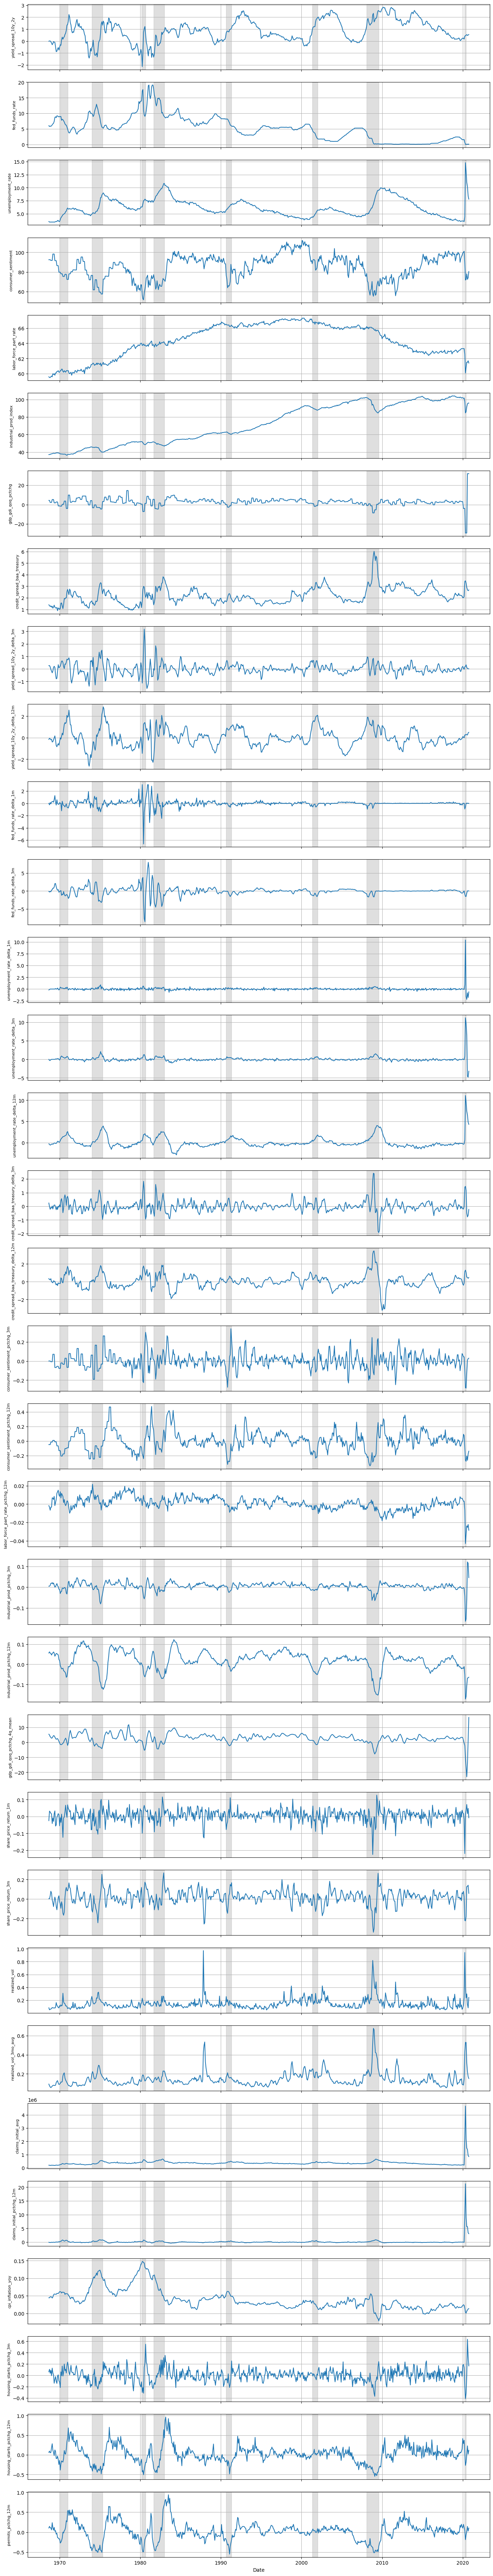

In [99]:

# 6. PLOT WITH SHADED RECESSIONS
rec = monthly['recession_flag'].loc[features.index]
starts = rec[rec.diff()==1].index
ends   = rec[rec.diff()==-1].index
if rec.iloc[0]==1:
    starts = starts.insert(0, rec.index[0])

fig, axes = plt.subplots(len(features.columns)-1, 1,
                         figsize=(14, 2.2*(len(features.columns)-1)), sharex=True)
for ax, col in zip(axes, features.columns.drop('recession_flag_3m_ahead')):
    ax.plot(features.index, features[col], label=col)
    for s,e in zip(starts, ends):
        ax.axvspan(s, e, color='gray', alpha=0.25)
    ax.set_ylabel(col, fontsize=8)
    ax.grid(True)
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

In [100]:
features.describe()

,yield_spread_10y_2y,fed_funds_rate,unemployment_rate,consumer_sentiment,labor_force_part_rate,industrial_prod_index,gdp_gdi_qoq_pctchg,credit_spread_baa_treasury,yield_spread_10y_2y_delta_3m,yield_spread_10y_2y_delta_12m,...,share_price_return_1m,share_price_return_3m,realized_vol,realized_vol_3mo_avg,claims_initial_avg,claims_initial_pctchg_12m,cpi_inflation_yoy,housing_starts_pctchg_3m,housing_starts_pctchg_12m,permits_pctchg_12m
count,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,...,626.000000,626.000000,626.000000,626.000000,6.260000e+02,626.000000,626.000000,626.000000,626.000000,626.000000
mean,0.852460,5.153658,6.162460,85.273962,64.333546,72.130216,2.767891,2.199681,0.003530,0.006933,...,0.005619,0.017614,0.145537,0.145395,3.725831e+05,0.111835,0.039937,0.006273,0.023222,0.028349
std,0.931894,3.903069,1.712882,12.332485,2.180464,22.603940,4.291716,0.716792,0.436995,0.835159,...,0.037248,0.074237,0.090195,0.075860,2.301548e+05,1.084635,0.029242,0.111779,0.223143,0.228501
min,-2.130000,0.050000,3.400000,51.700000,59.500000,36.388100,-29.300000,0.890000,-1.560000,-2.650000,...,-0.224867,-0.338856,0.047369,0.055696,1.812000e+05,-0.383507,-0.020972,-0.410013,-0.547970,-0.550343
25%,0.180000,1.750000,4.900000,76.100000,62.900000,50.999250,1.300000,1.690000,-0.210000,-0.540000,...,-0.012282,-0.018618,0.094524,0.100579,3.040625e+05,-0.100906,0.021080,-0.059974,-0.093890,-0.084527
50%,0.830000,5.240000,5.800000,88.400000,64.550000,69.290850,2.900000,2.110000,-0.030000,-0.035000,...,0.008357,0.022607,0.123937,0.124657,3.460000e+05,-0.034585,0.031891,0.007134,0.019654,0.037995
75%,1.497500,7.502500,7.300000,94.075000,66.300000,94.029075,4.600000,2.637500,0.200000,0.437500,...,0.027714,0.058874,0.166650,0.166382,4.021000e+05,0.078256,0.049265,0.063286,0.133099,0.130154
max,2.830000,19.100000,14.800000,112.000000,67.300000,104.103800,31.900000,6.010000,3.180000,2.870000,...,0.126674,0.267625,0.971439,0.675552,4.663250e+06,21.232420,0.147564,0.635875,0.961894,0.937568


In [101]:
features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 626 entries, 1968-08-31 to 2020-09-30
Freq: ME
Data columns (total 34 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   yield_spread_10y_2y                   626 non-null    float64
 1   fed_funds_rate                        626 non-null    float64
 2   unemployment_rate                     626 non-null    float64
 3   consumer_sentiment                    626 non-null    float64
 4   labor_force_part_rate                 626 non-null    float64
 5   industrial_prod_index                 626 non-null    float64
 6   gdp_gdi_qoq_pctchg                    626 non-null    float64
 7   credit_spread_baa_treasury            626 non-null    float64
 8   yield_spread_10y_2y_delta_3m          626 non-null    float64
 9   yield_spread_10y_2y_delta_12m         626 non-null    float64
 10  fed_funds_rate_delta_1m               626 non-null    floa

In [102]:
features.to_pickle("recession_features.pkl", compression="infer")

In [103]:
features = pd.read_pickle("recession_features.pkl")  # safe if source is trusted



In [104]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# load features
features = pd.read_pickle("recession_features.pkl")

# separate X and y
X = features.drop(columns="recession_flag_3m_ahead").values
y = features["recession_flag_3m_ahead"].values

# simple 70/15/15 split indices
n = len(features)
n_train = int(n * 0.60)
n_val   = int(n * 0.30)
train_idx = slice(0, n_train)
val_idx   = slice(n_train, n_train + n_val)
test_idx  = slice(n_train + n_val, None)

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

In [105]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# persist scaler for later use
joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']

In [106]:
from statsmodels.tsa.arima.model import ARIMA
